In [1]:
# importing libraries
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, roc_auc_score, accuracy_score
from sklearn.preprocessing import label_binarize
from sklearn.datasets import load_digits

In [2]:
# loading the datasets
import numpy as np
digits = load_digits()

In [3]:
#selecting features and target
X = digits.data
Y = digits.target
Y_bin = label_binarize(Y, classes=np.unique(Y)) 

# splitting training and testing data (80% train and 20% test)
X_train, X_test, Y_train, Y_test, Y_bin_train, Y_bin_test = train_test_split(X, Y, Y_bin, test_size=0.2, random_state=72, shuffle=True)

# standardizing the features 
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# defining the LDA model
model_lda = LinearDiscriminantAnalysis() #(Kaggle,2024) (Ashraf, K. 2024)

# fit the model
model_lda.fit(X_train, Y_train)

LinearDiscriminantAnalysis()

In [5]:
# Predictions  
pred_lda = model_lda.predict(X_test)  
y_prob_lda = model_lda.predict_proba(X_test)  

# Evaluations  
bal_acc_lda = balanced_accuracy_score(Y_test, pred_lda) #measuring balanced accuracy (Scikit,2025)
roc_lda = roc_auc_score(Y_test, y_prob_lda, multi_class="ovr", average="macro") #calculating ROC score (SciKit,2025)

print(f"LDA Balanced Accuracy: {bal_acc_lda:.4f}")  
print(f"LDA ROC-AUC Score: {roc_lda:.4f}")

LDA Balanced Accuracy: 0.9457
LDA ROC-AUC Score: 0.9968


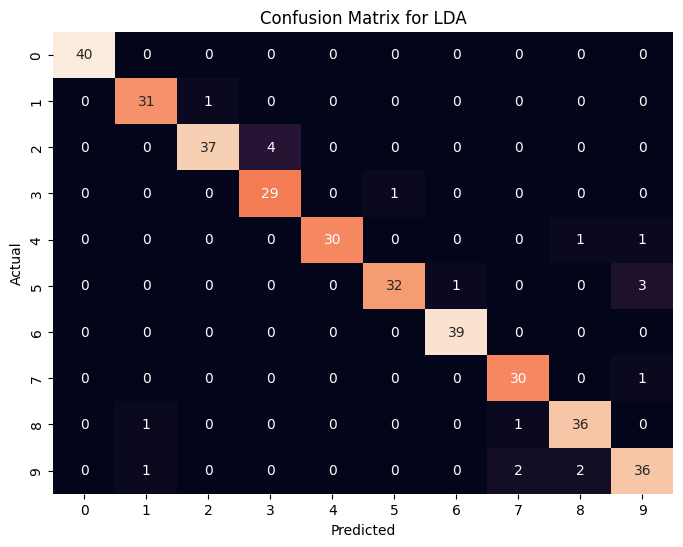

In [6]:
# Confusion Matrix 
cm_lda = confusion_matrix(Y_test, pred_lda)
 
plt.figure(figsize=(8, 6))  
sns.heatmap(cm_lda, annot=True, fmt="d", cbar=False)  
plt.xlabel("Predicted")  
plt.ylabel("Actual")  
plt.title("Confusion Matrix for LDA")  
plt.show()  


In [ ]:
# hyperparameter tuning using GridSearchCV
param_grid = [
    {"solver": ["svd"]},
    {"solver": ["lsqr", "eigen"], "shrinkage": ["auto"]}  # Including shrinkage parameter
]

# perform GridSearchCV for LDA model # (Kaggle,2019) (Hernández, J. 2019)
grid_search_lda = GridSearchCV(LinearDiscriminantAnalysis(), param_grid, cv=5, scoring="balanced_accuracy", verbose=1)
grid_search_lda.fit(X_train, Y_train)

# best parameters
print(f"\nBest LDA Parameters: {grid_search_lda.best_params_}")

# get the best LDA model from GridSearchCV
best_lda = grid_search_lda.best_estimator_

# train the optimized LDA model
best_lda.fit(X_train, Y_train)

# predictions
pred_lda = best_lda.predict(X_test)
prob_lda = best_lda.predict_proba(X_test)

# evaluations
bal_acc_lda = balanced_accuracy_score(Y_test, pred_lda)
roc_lda = roc_auc_score(Y_bin_test, prob_lda, multi_class='ovr',average="macro")

print(f"LDA Balanced Accuracy: {bal_acc_lda:.4f}")
print(f"LDA ROC-AUC Score: {roc_lda:.4f}")

Fitting 5 folds for each of 3 candidates, totalling 15 fits

Best LDA Parameters: {'shrinkage': 'auto', 'solver': 'lsqr'}
LDA Balanced Accuracy: 0.9545
LDA ROC-AUC Score: 0.9972


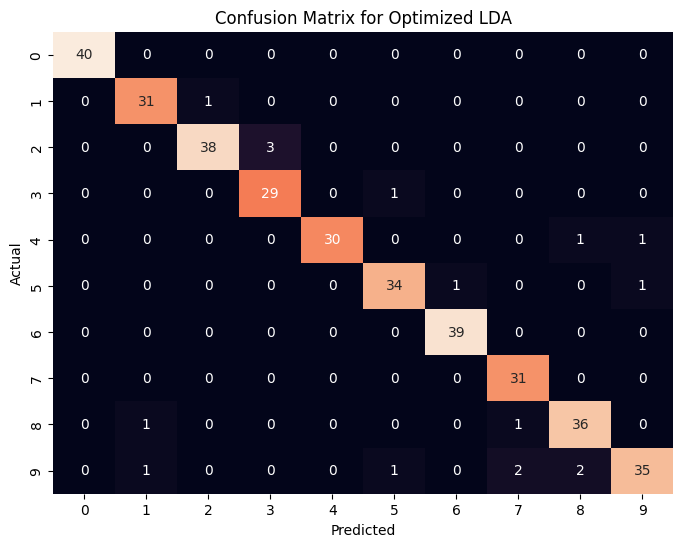

In [8]:
# Confusion Matrix
cm_optimal_model_lda = confusion_matrix(Y_test, pred_lda)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_optimal_model_lda, annot=True, fmt="d", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Optimized LDA")
plt.show()
